In [1]:
import numpy as np
import os
from scipy.ndimage import distance_transform_edt

def parse_c_file(file_path):
    """
    Parse the OpenFOAM C file to extract (x,y) coordinates of cell centers.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    start_idx = None
    num_centres = None
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break

    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or number of cell centers in C file.")

    coordinates = []
    for line in lines[start_idx:start_idx+num_centres]:
        if "(" in line and ")" in line:
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])
    
    return np.array(coordinates)

def reshape_trajectory_data(sim_data, cell_centers, grid_shape):
    """
    Reshape simulation data to structured (128,128) grid, handling missing cells.
    Adds:
    - Ux, Uy, p (from OpenFOAM)
    - Geometry mask (1 for holes, 0 for fluid)
    - Reynolds number (constant across trajectory)
    - Signed Distance Field (SDF)
    """
    n_rows, n_cols = grid_shape
    T, num_cells, num_channels = sim_data.shape
    # assert num_channels == 4, "Expected 4 channels: Ux, Uy, p, Re"

    # Compute domain boundaries from cell centers
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])

    # Initialize grid with zeros for Ux, Uy, p
    reshaped = np.zeros((T, n_rows, n_cols, 6))

    # Create geometry mask initialized to 1 (hole)
    mask = np.ones((n_rows, n_cols))

    # Extract Reynolds number from first available cell (assumed constant for trajectory)
    Re_value = sim_data[0, 0, 3]  # Take first cell's Re for the entire grid

    # Precompute mapping for each simulation cell
    mapping = []
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        mapping.append((row, col))
        mask[row, col] = 0  # Fluid region

    # Compute SDF
    outside_dist = distance_transform_edt(mask == 0)
    inside_dist = distance_transform_edt(mask == 1)
    sdf_field = outside_dist - inside_dist

    # Assign Reynolds number to all cells in the grid
    reshaped[:, :, :, 3] = Re_value  # Ensure ALL cells, including holes, get Re value

    # Process each timestep
    for t in range(T):
        for i, (row, col) in enumerate(mapping):
            reshaped[t, row, col, :3] = sim_data[t, i, :3]  # Ux, Uy, p
            reshaped[t, row, col, 3] = sim_data[t, i, 3]  # Reynolds number

        reshaped[t, :, :, 4] = mask  # Geometry mask
        reshaped[t, :, :, 5] = sdf_field  # Signed Distance Field

    return reshaped

def process_and_save_combined_dataset(data_dir, c_file_path, output_path):
    """
    - Loads multiple OpenFOAM `.npy` files from `data_dir`
    - Reshapes to (128,128) format
    - Adds Reynolds number, geometry mask, and SDF
    - Saves as a single `.npy` file
    """
    all_files = [f for f in os.listdir(data_dir) if f.endswith(".npy")]
    all_data = []

    cell_centers = parse_c_file(c_file_path)

    for file in all_files:
        file_path = os.path.join(data_dir, file)
        sim_data = np.load(file_path)  # Shape: (num_trajectories, timesteps, num_cells, 4)
        
        num_trajectories = sim_data.shape[0]
        reshaped_trajectories = []
        
        for i in range(num_trajectories):
            reshaped = reshape_trajectory_data(sim_data[i], cell_centers, (128, 128))
            reshaped_trajectories.append(reshaped)

        all_data.append(np.array(reshaped_trajectories))

    final_dataset = np.concatenate(all_data, axis=0)  # Merge all trajectories
    np.save(output_path, final_dataset)
    print(f"Saved combined dataset to {output_path}")

# Example usage
data_dir = "/data/user_data/namancho/FPO_external_irr_new"  # Directory containing OpenFOAM .npy simulation outputs
c_file_path = "/home/namancho/openfoam/openfoam_project/Flowbench_Openfoam/FPO_External/Irregular/Design_Point_0/0/C"  # OpenFOAM C file with cell centers
output_path = "/data/user_data/namancho/FPO_external_irr_new/final_dataset.npy"  # Output path

process_and_save_combined_dataset(data_dir, c_file_path, output_path)


Saved combined dataset to /data/user_data/namancho/FPO_external_irr_new/final_dataset.npy


In [3]:
test = np.load(output_path)
print(test.shape)

(600, 20, 128, 128, 6)


Dataset shape: (600, 20, 128, 128, 6)


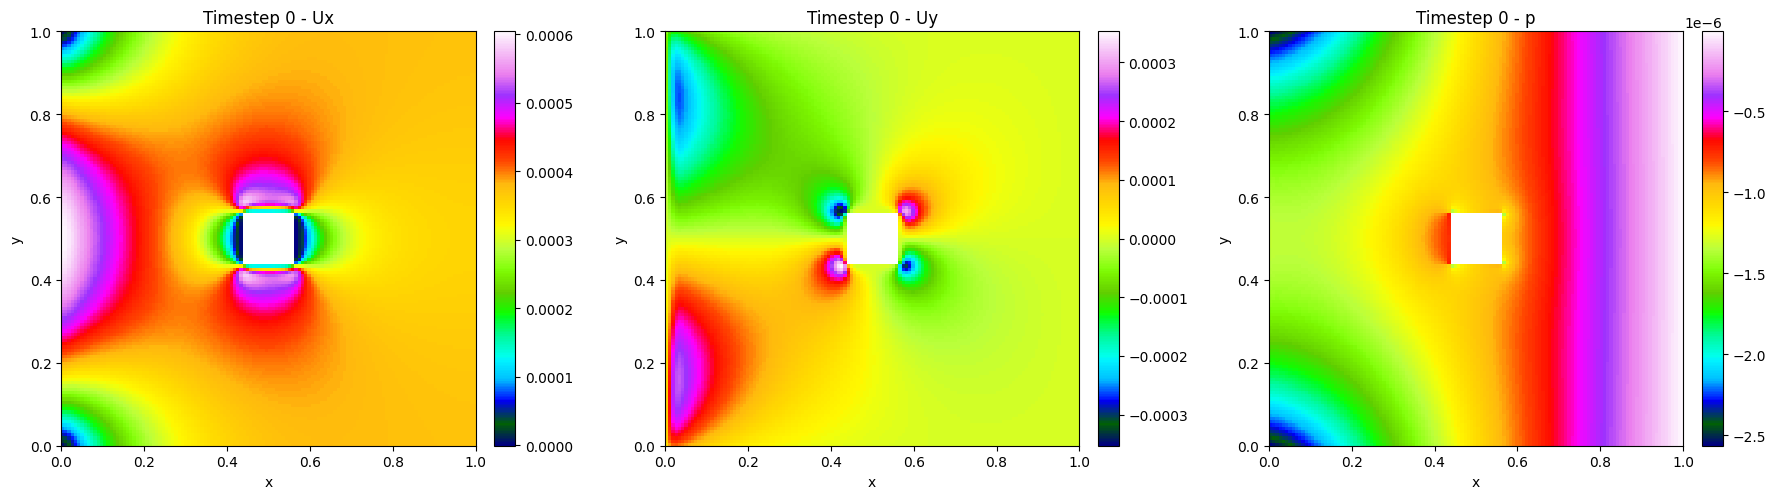

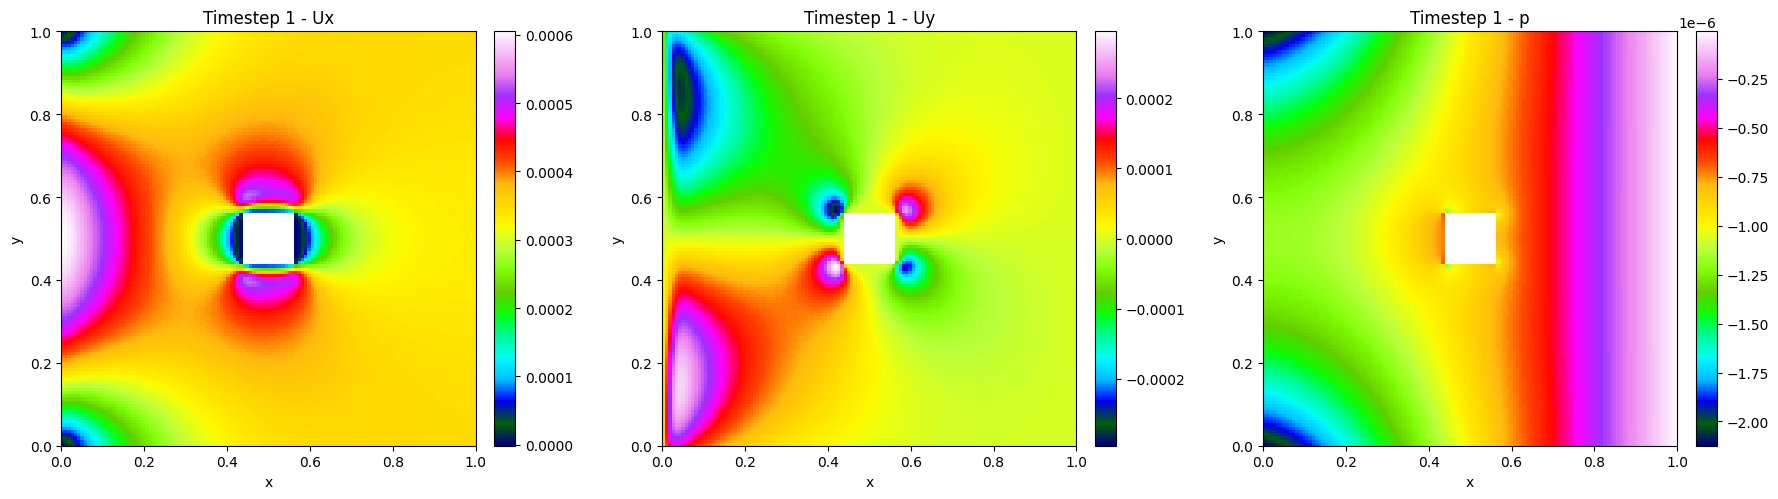

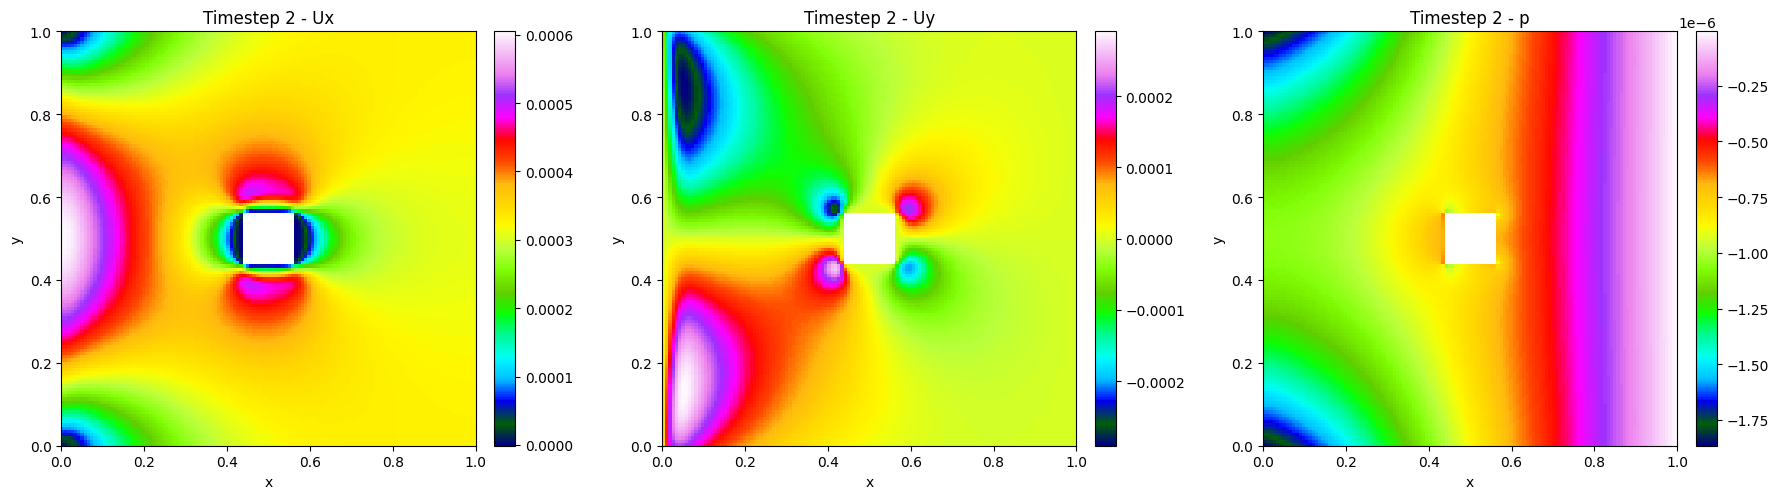

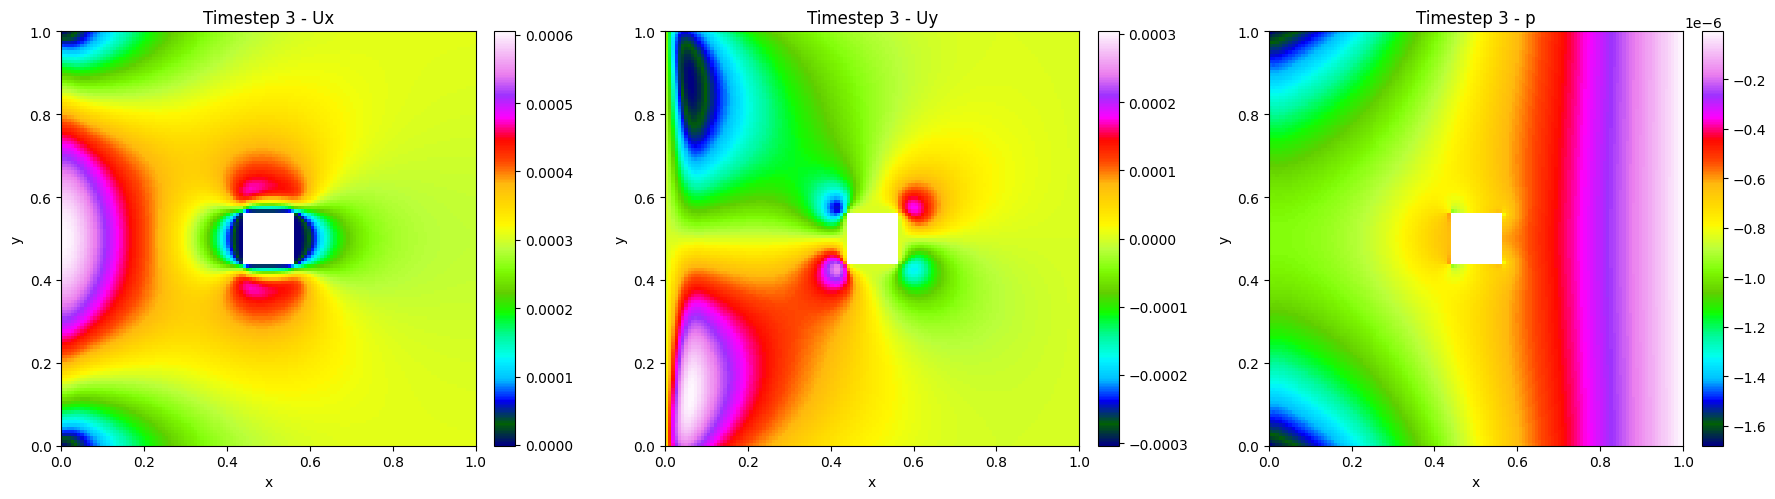

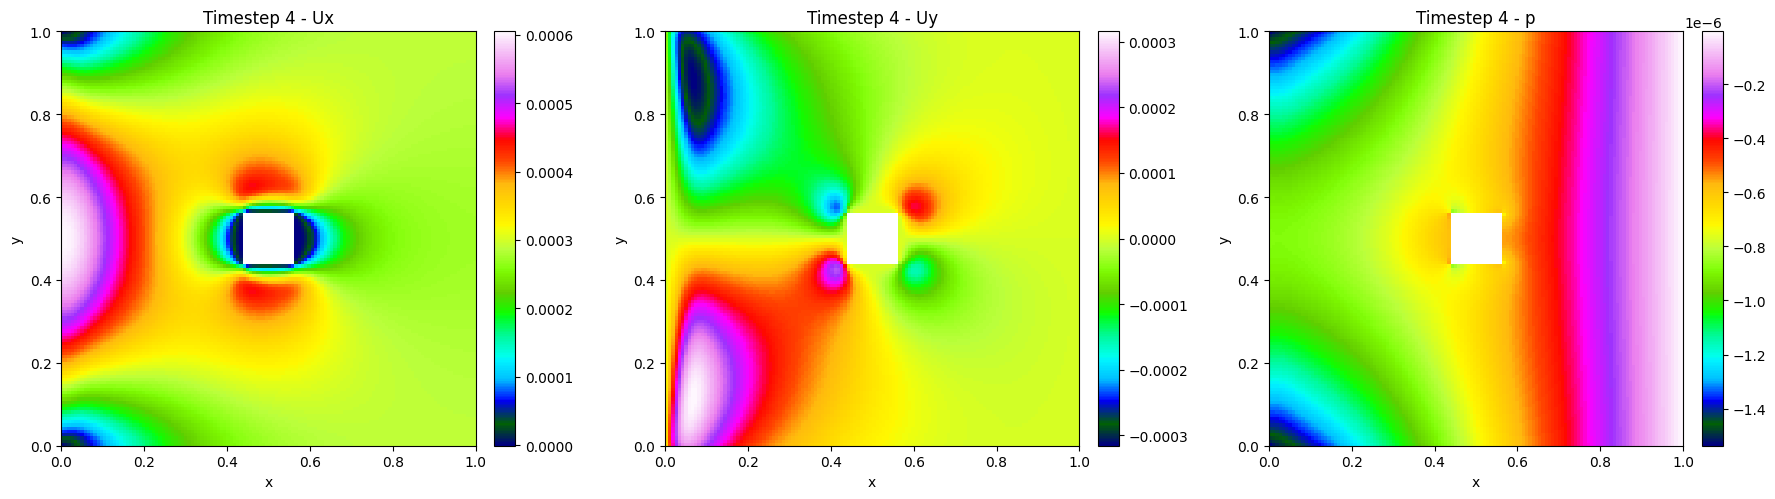

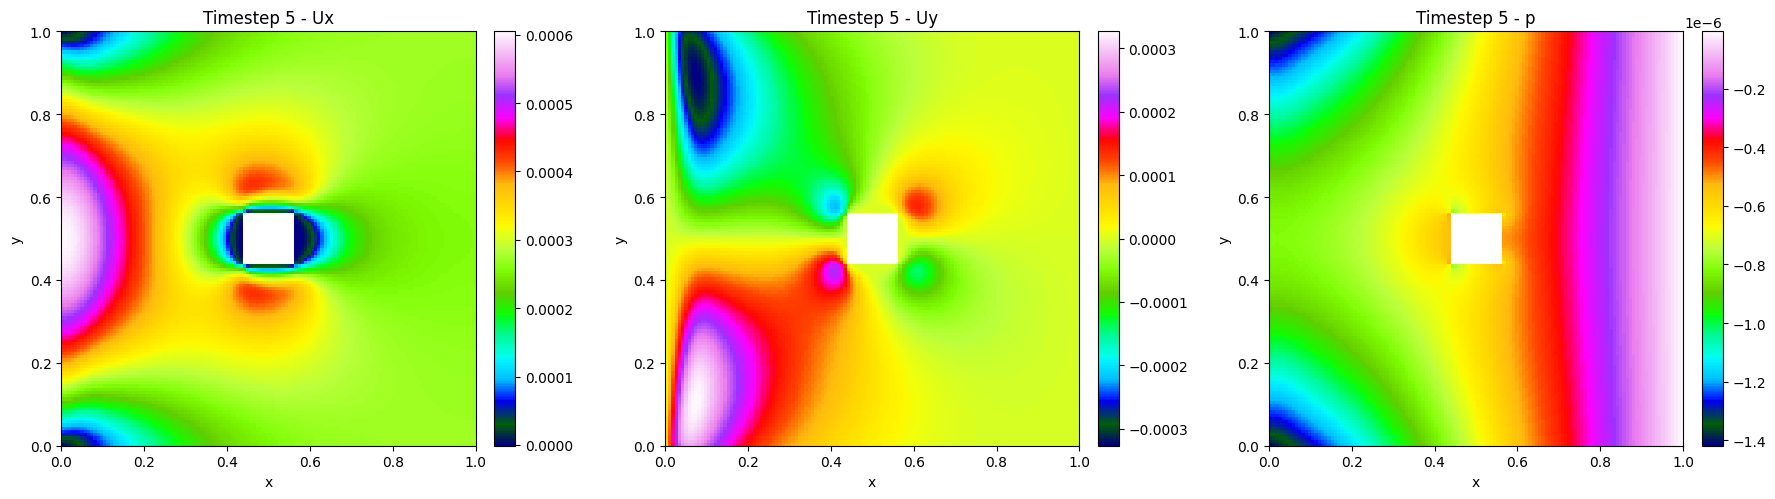

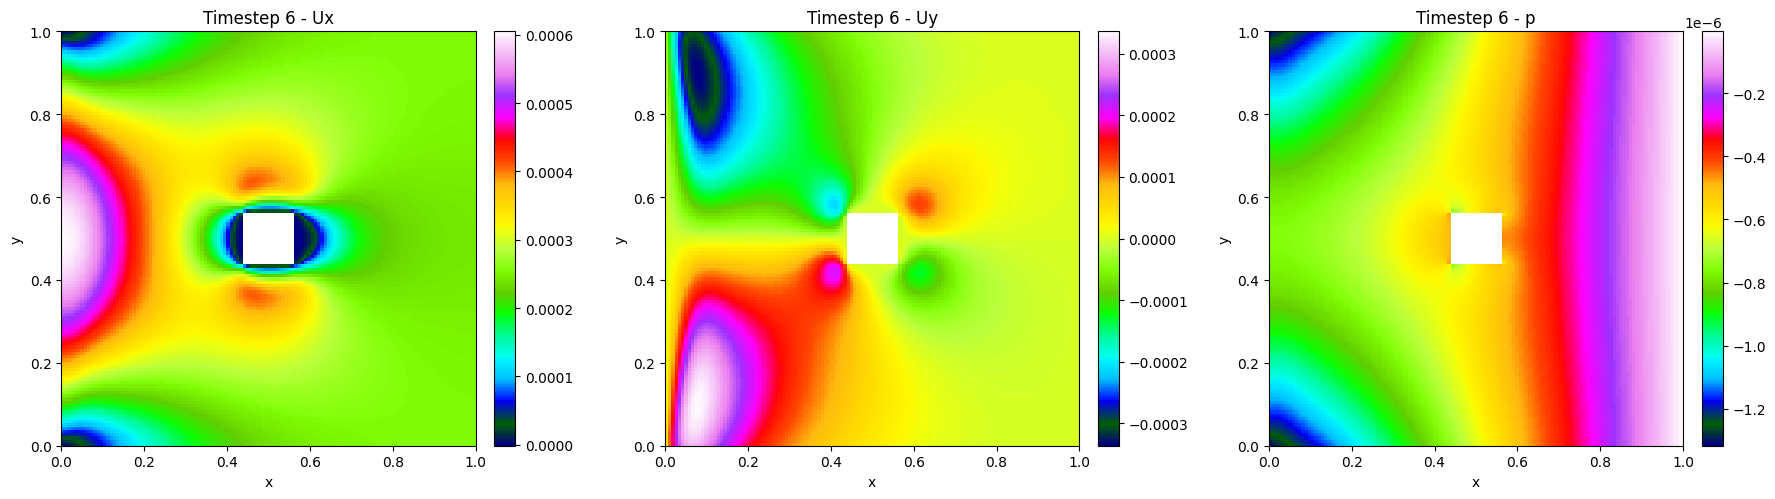

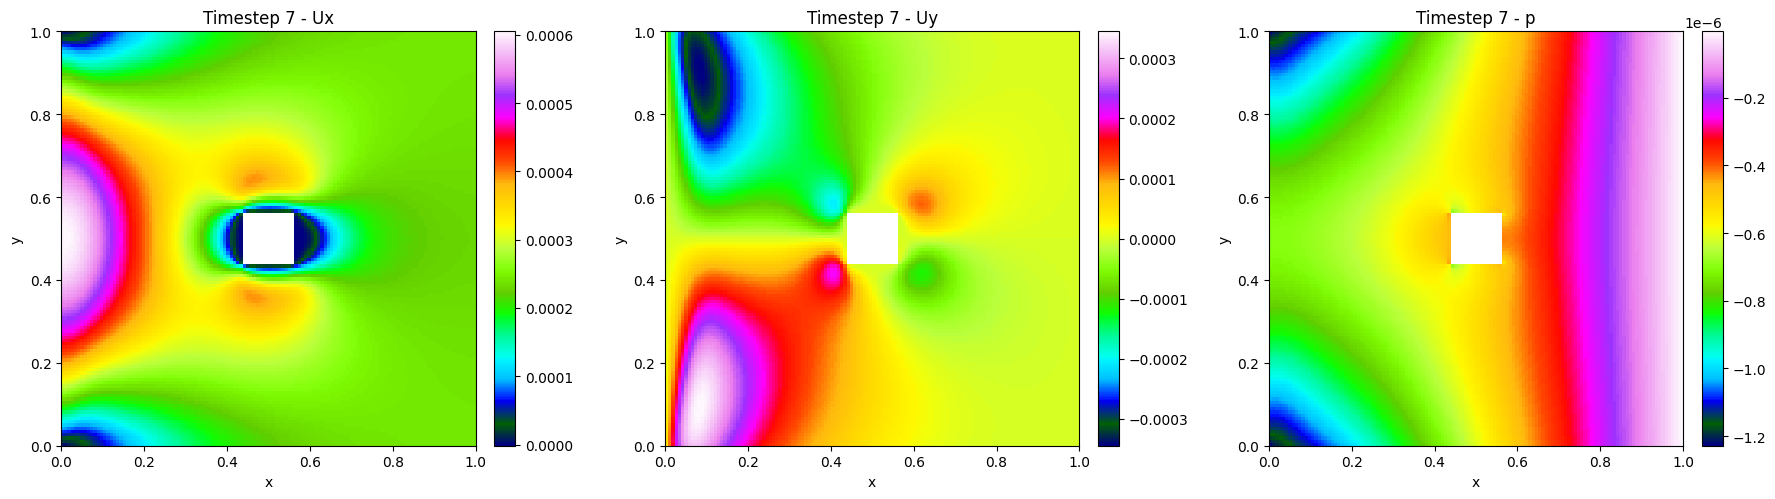

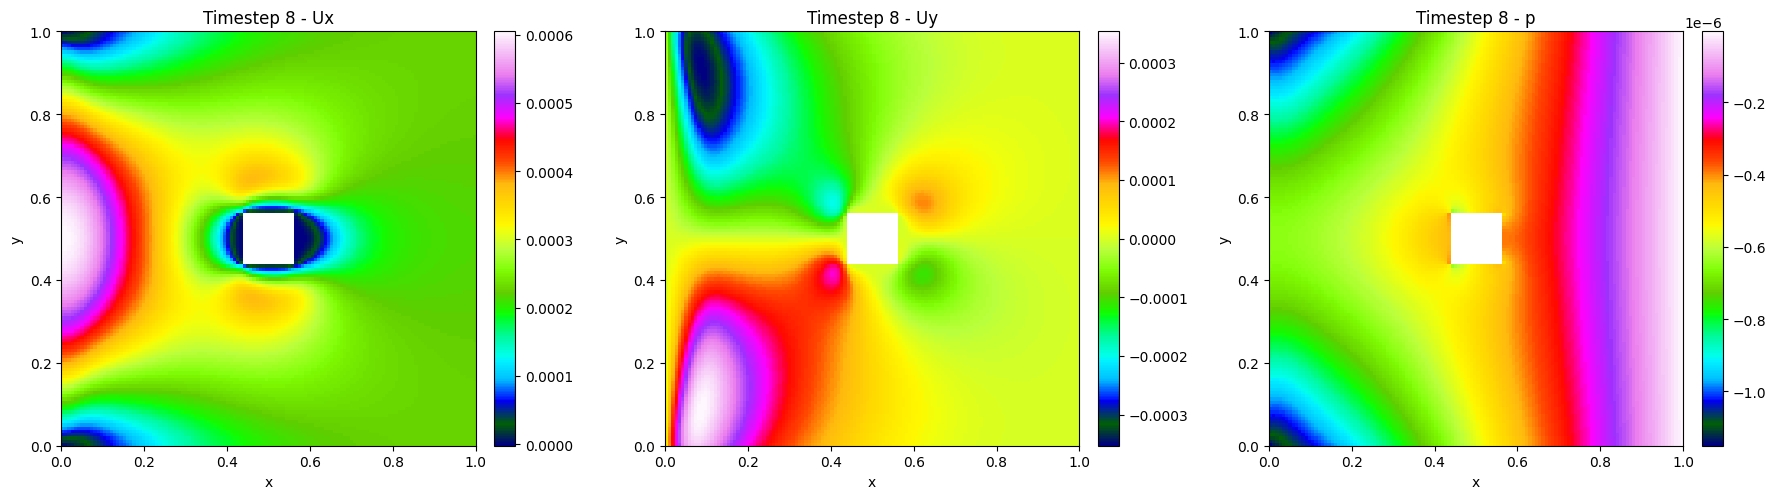

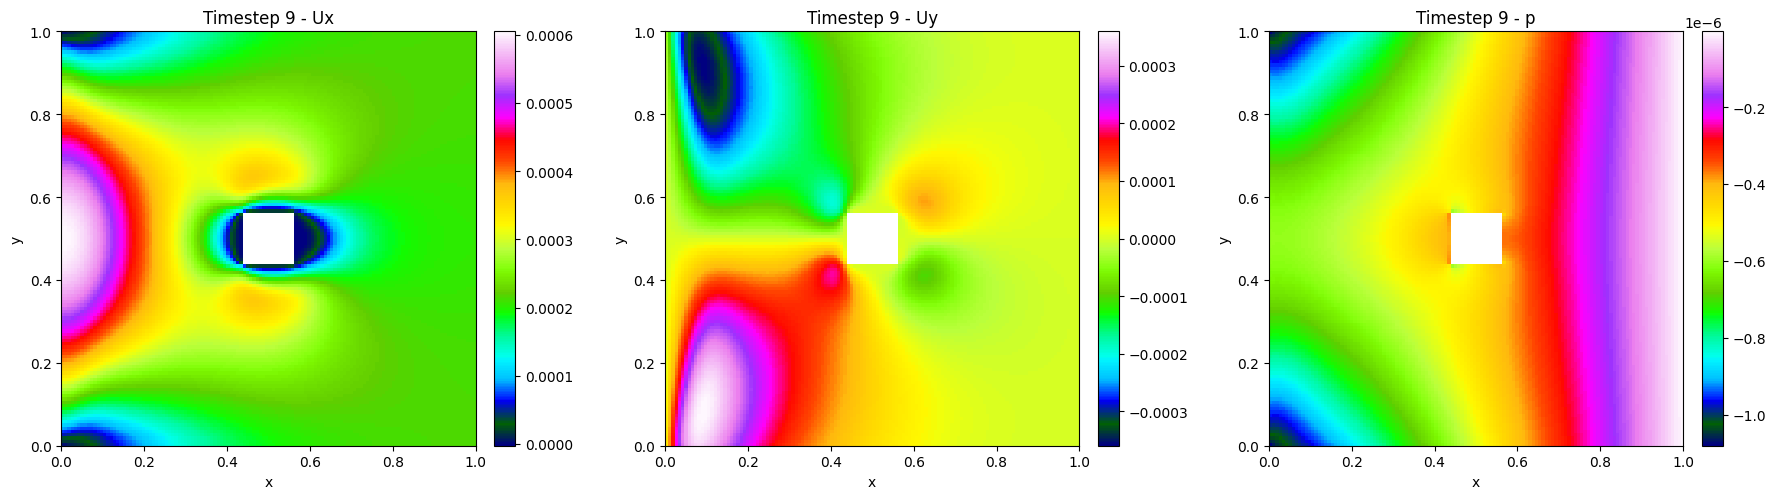

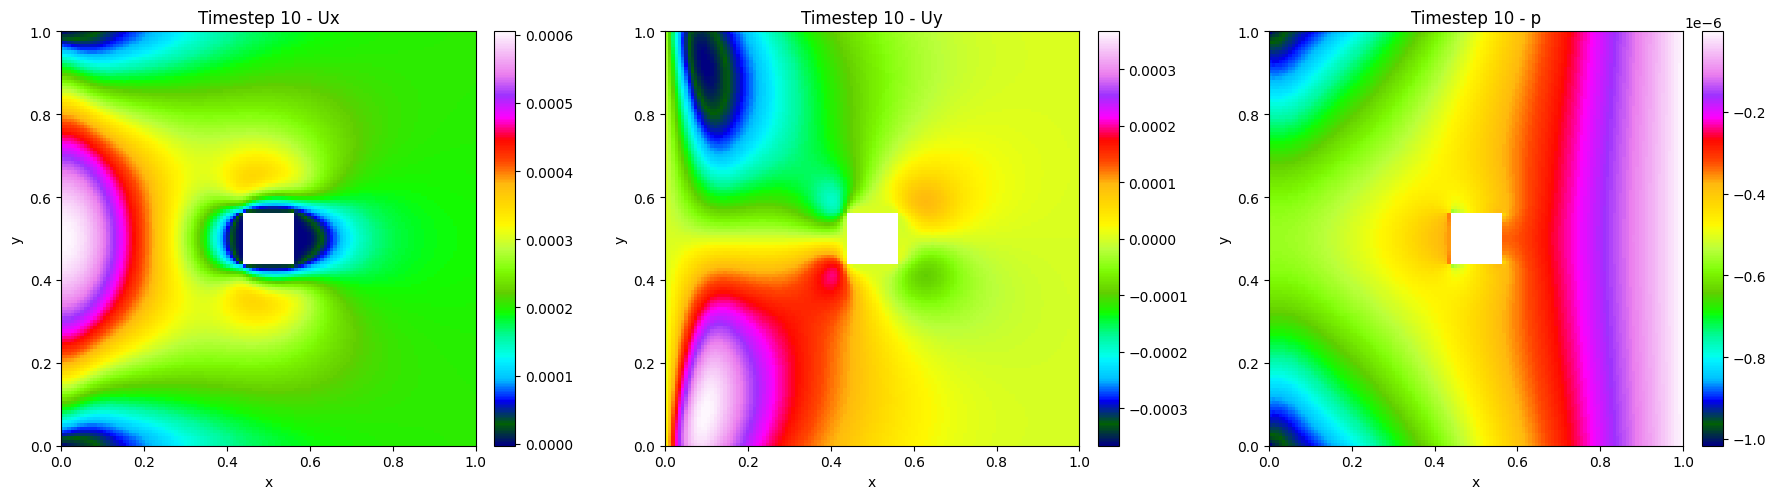

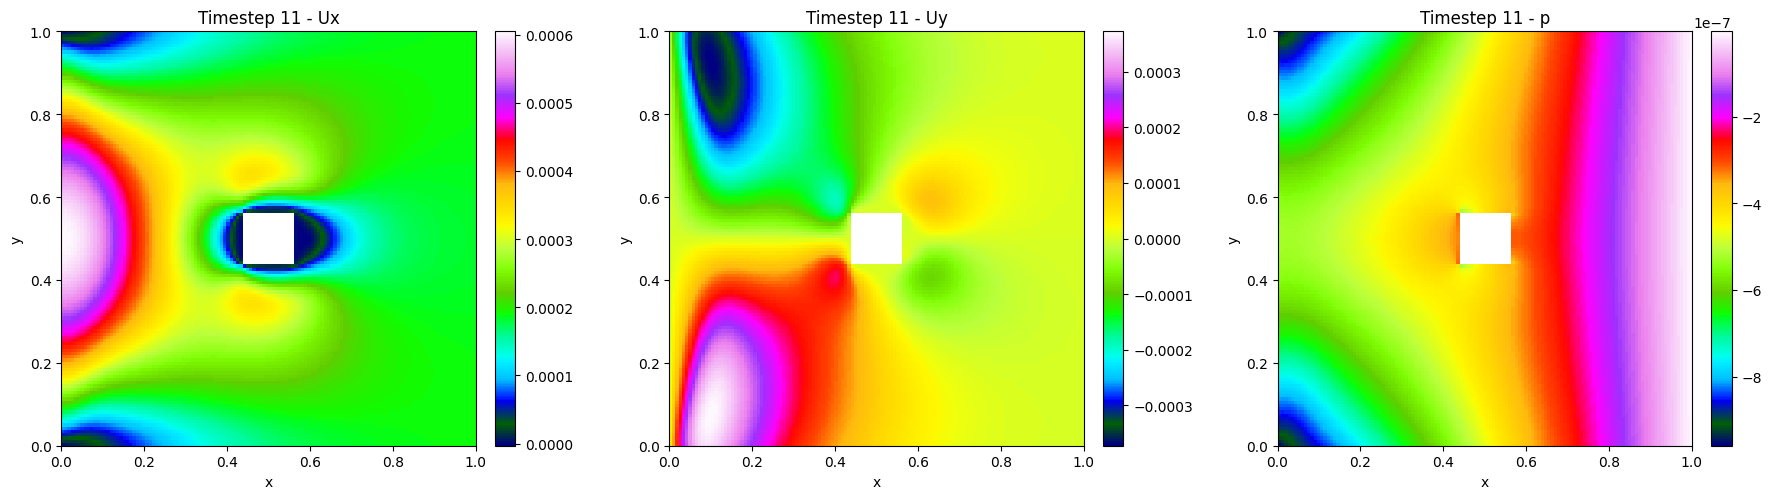

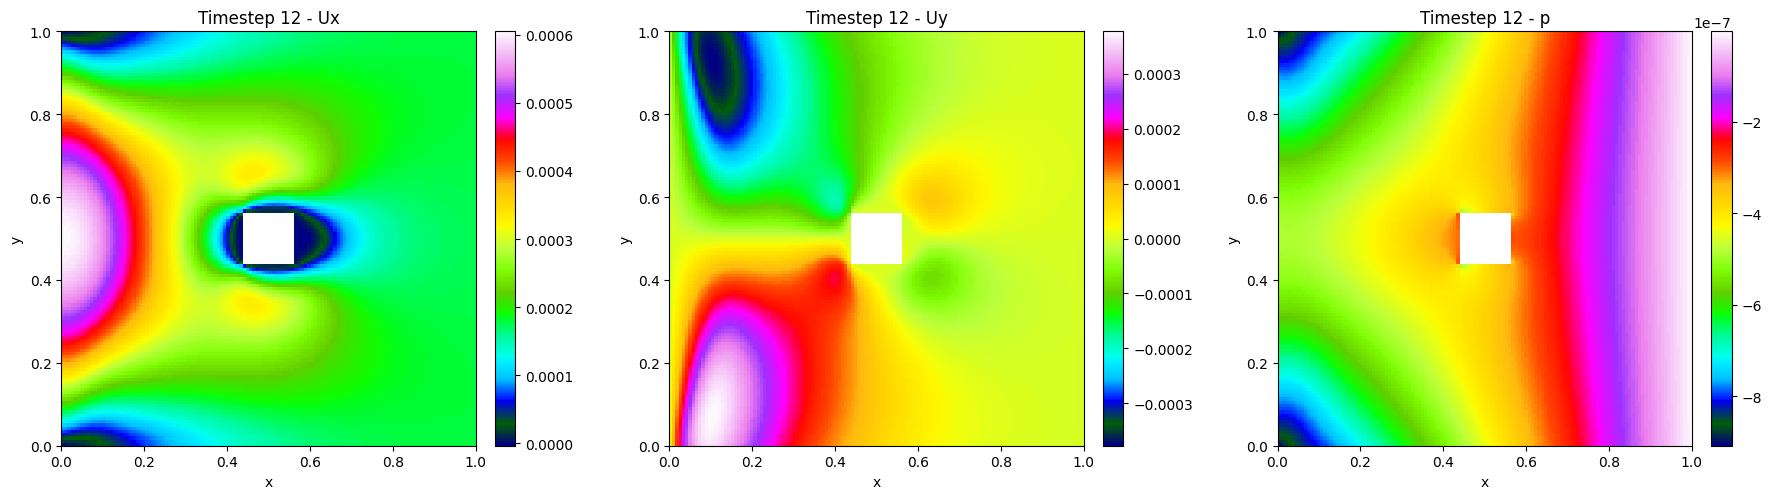

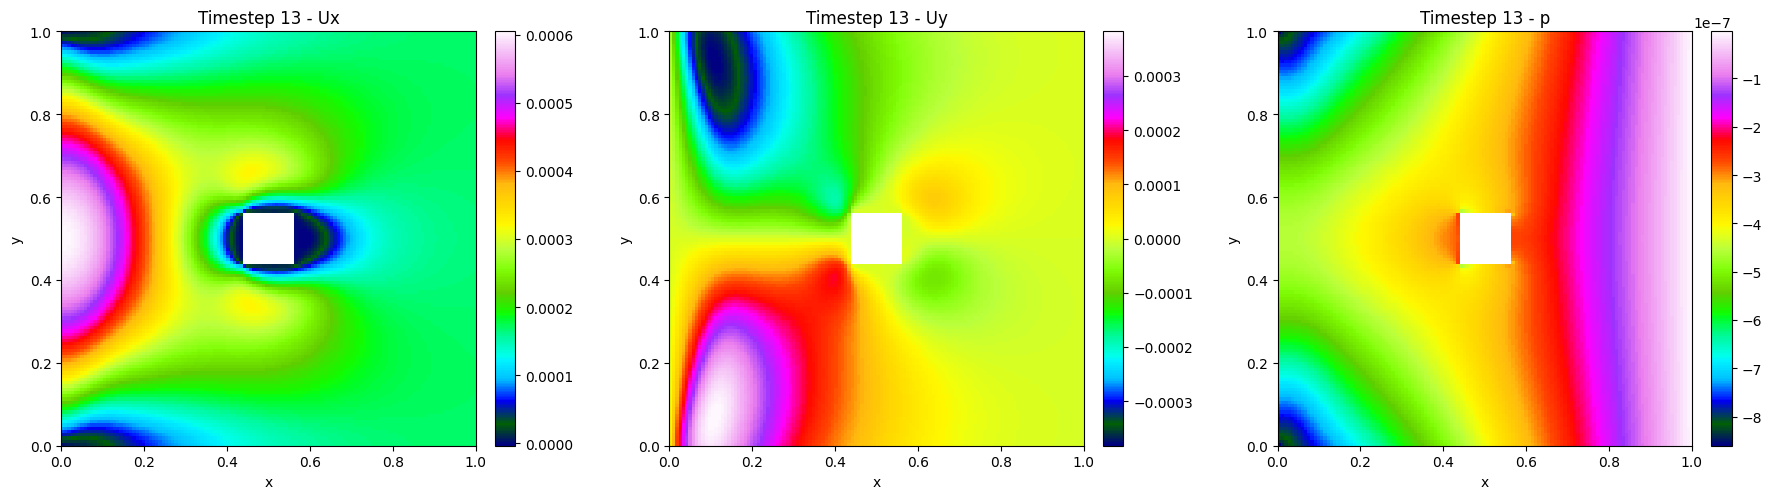

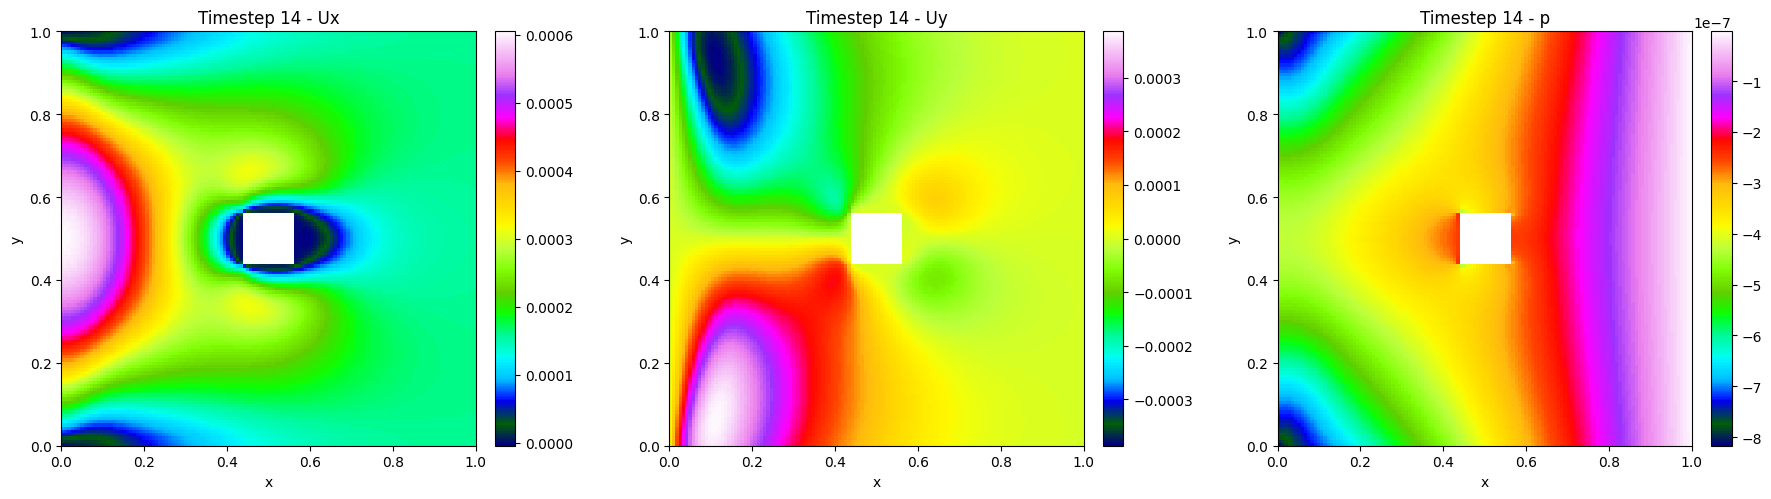

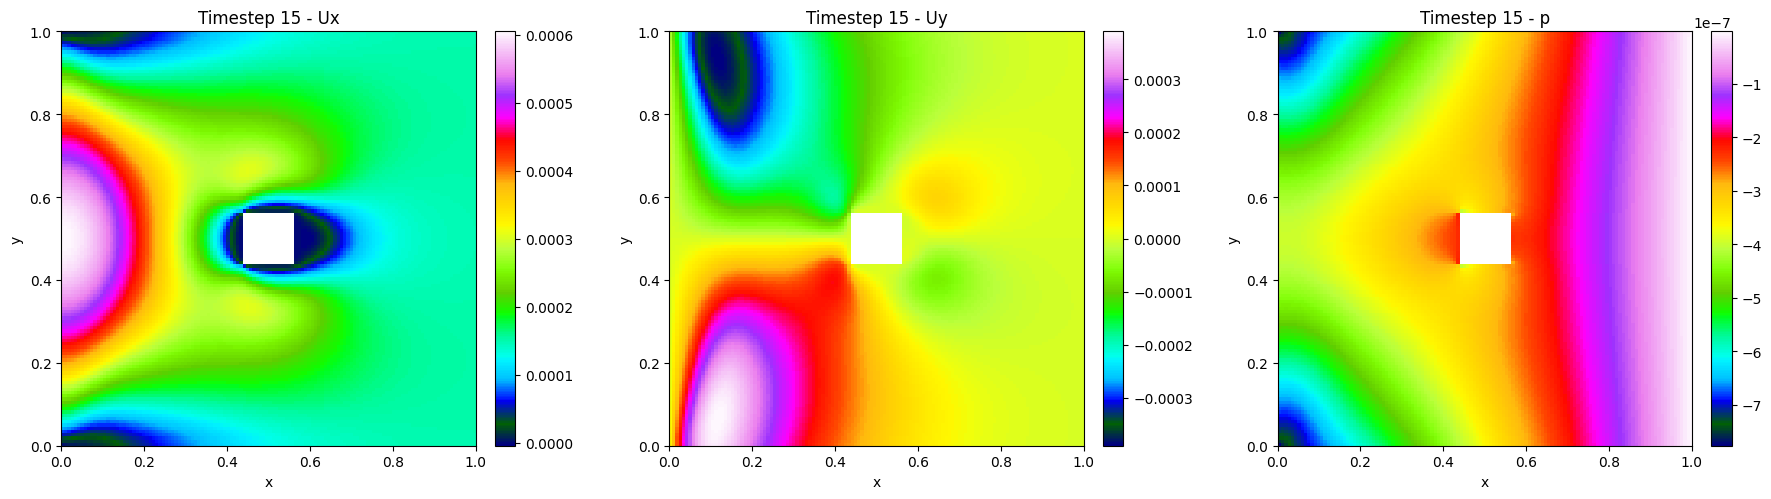

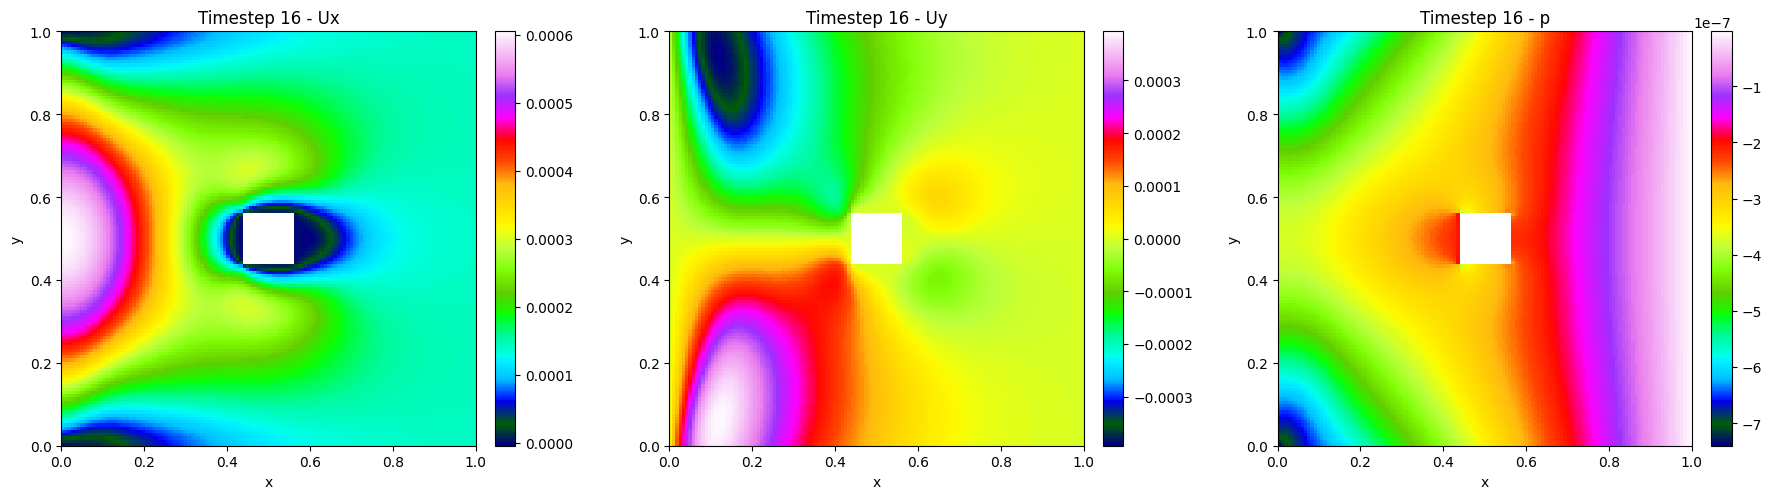

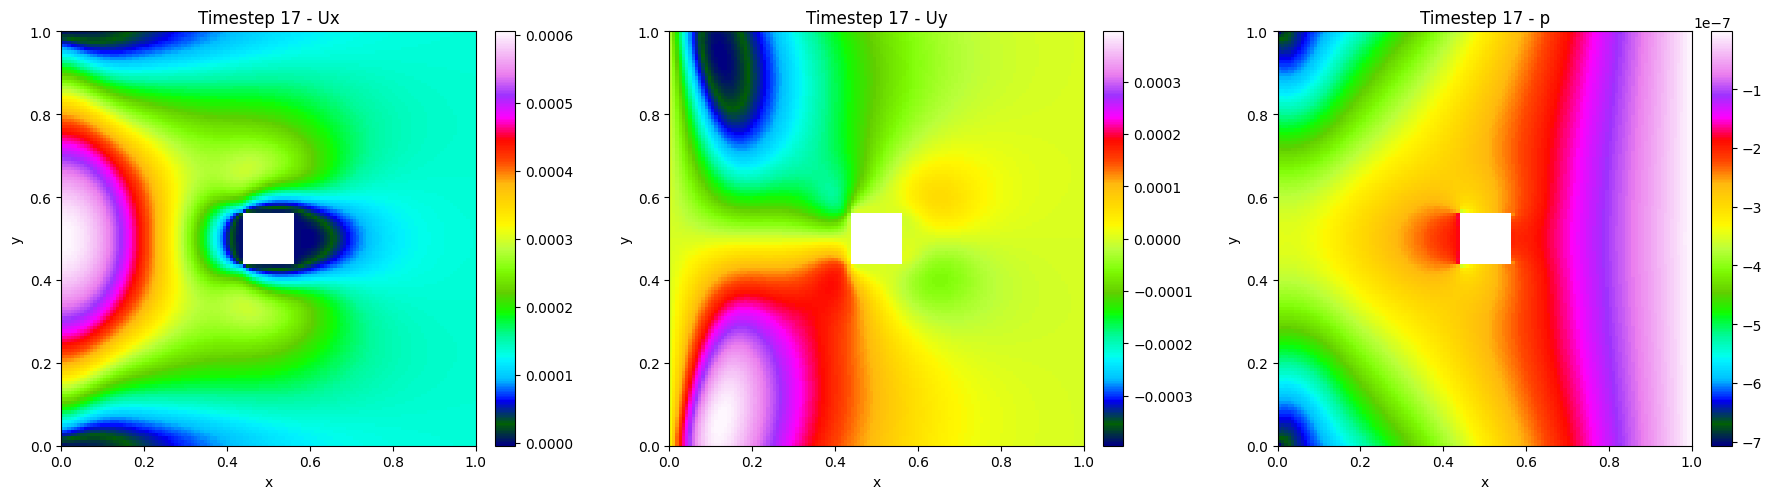

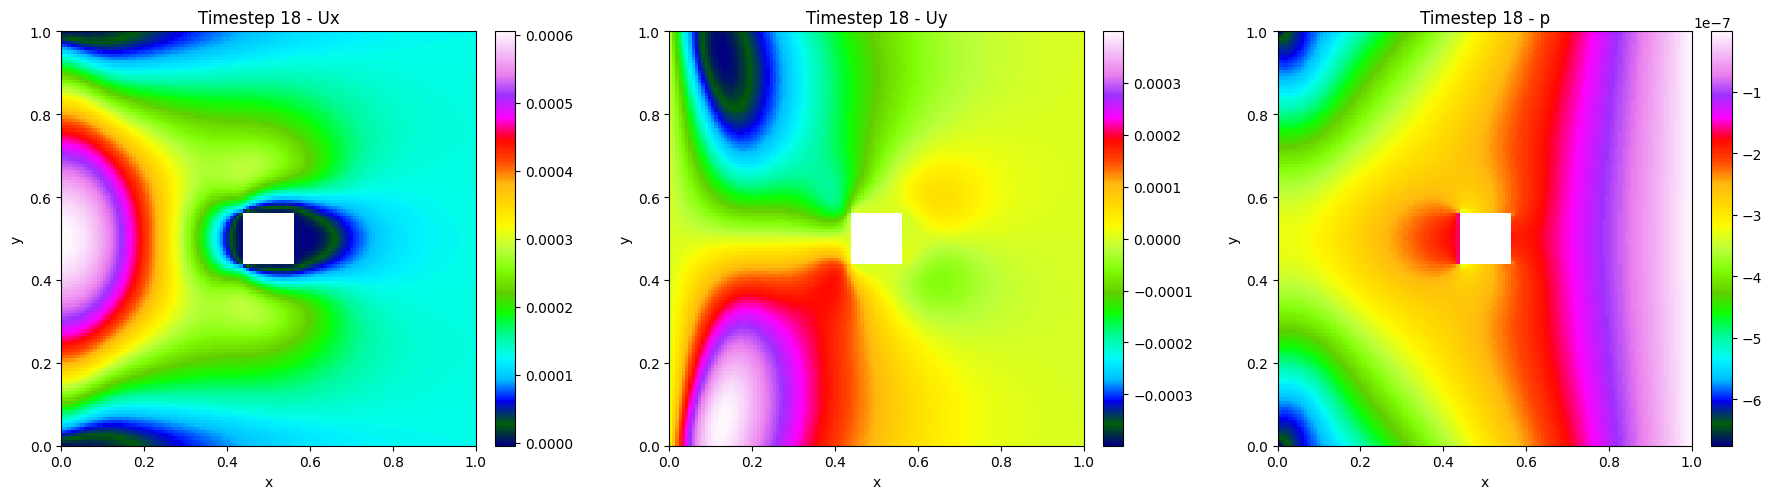

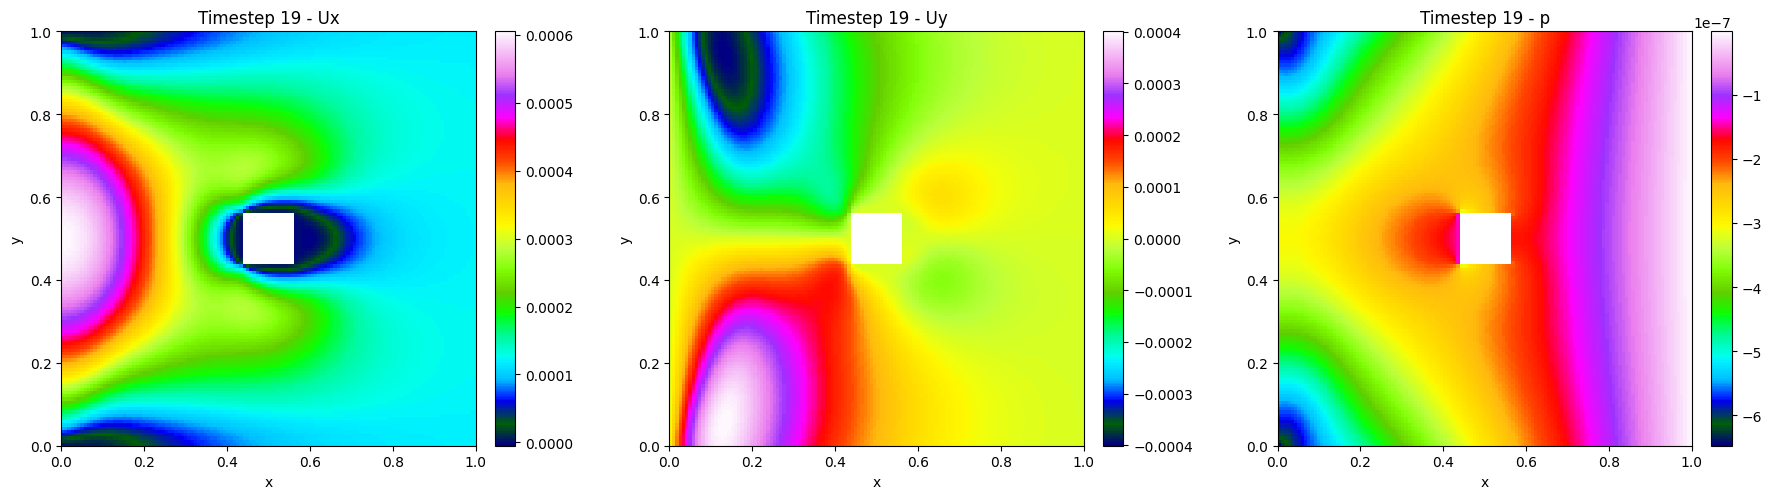

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the reshaped dataset (update as needed)
DATA_PATH = output_path

def visualize_dataset(data, trajectory_index=0):
    """
    Visualize all timesteps for the given trajectory while excluding hole cells.
    
    Data is assumed to have shape:
       (num_trajectories, timesteps, n_rows, n_cols, final_channels)
    where final_channels: 0=Ux, 1=Uy, 2=p, 3=hole indicator.
    
    This function displays Ux, Uy, and p for each timestep.
    """
    # Extract the trajectory to visualize
    traj_data = data[trajectory_index]  # shape: (timesteps, n_rows, n_cols, final_channels)
    timesteps, n_rows, n_cols, final_channels = traj_data.shape
    channel_names = ['Ux', 'Uy', 'p']
    
    for t in range(timesteps):
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        for ch in range(3):
            field = traj_data[t, :, :, ch]
            mask = traj_data[t, :, :, 4]  # Hole indicator
            masked_field = np.ma.masked_where(mask == 1, field)  # Mask out hole cells
            
            ax = axs[ch]
            cmap = "gist_ncar" if ch in [0, 1] else "gist_ncar"
            im = ax.imshow(masked_field, cmap=cmap, origin='upper', extent=[0, 1, 0, 1])
            ax.set_title(f"Timestep {t} - {channel_names[ch]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

def main():
    # Load the reshaped dataset
    dataset = np.load(DATA_PATH)
    print("Dataset shape:", dataset.shape)
    
    # Visualize the first trajectory (or change trajectory_index as needed)
    visualize_dataset(dataset, trajectory_index=0)

if __name__ == "__main__":
    main()
